In [1]:
import numpy as np 
import pandas as pd
import re 

# The Project

The idea here is to simulate the FIFA 2022 World Cup games with machine learning, in order to predict the competition's winner. The project uses two datasets: [International football results from 1872 to 2022](https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017) and [FIFA World Ranking 1992-2022](https://www.kaggle.com/datasets/cashncarry/fifaworldranking)

I've used the same logic that was used in the [Soccer World Cup 2018 Winner
](https://www.kaggle.com/code/agostontorok/soccer-world-cup-2018-winner) notebook, that models the problem as binary classification one. I used this to make more easy to analyze model's results, so the model predicts between win from home team and draw/win from away team. Then, to remove the advantage of away team, I predicted the results changing teams from away and home (because there is not home advantage in World Cup), and used as probabilities the mean of the two predictions. 

# Data Preparation

Here, I'll prepare the data to apply feature engineering methods that will create the database in order to apply Machine Learning algorithms.

In [2]:
df =  pd.read_csv("data/results.csv")

In [3]:
df.head()

date home_team away_team  home_score  away_score tournament     city  \
0  1872-11-30  Scotland   England         0.0         0.0   Friendly  Glasgow   
1  1873-03-08   England  Scotland         4.0         2.0   Friendly   London   
2  1874-03-07  Scotland   England         2.0         1.0   Friendly  Glasgow   
3  1875-03-06   England  Scotland         2.0         2.0   Friendly   London   
4  1876-03-04  Scotland   England         3.0         0.0   Friendly  Glasgow   

    country  neutral  
0  Scotland    False  
1   England    False  
2  Scotland    False  
3   England    False  
4  Scotland    False

In [4]:
df.dtypes

date           object
home_team      object
away_team      object
home_score    float64
away_score    float64
tournament     object
city           object
country        object
neutral          bool
dtype: object

In [5]:
df["date"] = pd.to_datetime(df["date"])

In [6]:
df.isna().sum()

date          0
home_team     0
away_team     0
home_score    1
away_score    1
tournament    0
city          0
country       0
neutral       0
dtype: int64

In [7]:
df = df.dropna()

The dataset used will be the FIFA Games between 2018, from after the 2018 World Cup to the last games before the 2022 World Cup. The idea is to analyze just the games played at the preparation and classification to WC.

In [8]:
df[(df["date"] >= "2018-6-14")].reset_index(drop=True)['date'].min()

Timestamp('2018-06-14 00:00:00')

In [9]:
df = df.query("date >= '2018-6-14'").reset_index(drop=True)

In [10]:
df.home_team.value_counts()

United States    45
Mexico           41
Japan            39
Brazil           39
South Korea      38
                 ..
Bhutan            1
Tonga             1
Alderney          1
Saint Helena      1
Chameria          1
Name: home_team, Length: 247, dtype: int64

In [11]:
rank = pd.read_csv("data/fifa_ranking-2022-10-06.csv")

In [12]:
rank.head()

rank  country_full country_abrv  total_points  previous_points  \
0     1       Germany          GER          57.0              0.0   
1    96         Syria          SYR          11.0              0.0   
2    97  Burkina Faso          BFA          11.0              0.0   
3    99        Latvia          LVA          10.0              0.0   
4   100       Burundi          BDI          10.0              0.0   

   rank_change confederation   rank_date  
0            0          UEFA  1992-12-31  
1            0           AFC  1992-12-31  
2            0           CAF  1992-12-31  
3            0          UEFA  1992-12-31  
4            0           CAF  1992-12-31

In [13]:
rank["rank_date"] = pd.to_datetime(rank["rank_date"])
rank = rank.query("rank_date >= '2018-6-14'").reset_index(drop=True)

Some teams in the World Cup have different names in the ranking's dataset. So, it's needed to adjust. 

In [14]:
rank["country_full"] = rank["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States")

The merge is made in order to get a dataset FIFA games and its rankings.

O método **ffill** propaga a última informação até a próxima informação válida

In [15]:
rank = rank.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()

In [16]:
rank.head()

rank_date   rank country_full country_abrv  total_points  previous_points  \
0 2018-07-01  146.0  Afghanistan          AFG        1161.0           1161.0   
1 2018-07-02  146.0  Afghanistan          AFG        1161.0           1161.0   
2 2018-07-03  146.0  Afghanistan          AFG        1161.0           1161.0   
3 2018-07-04  146.0  Afghanistan          AFG        1161.0           1161.0   
4 2018-07-05  146.0  Afghanistan          AFG        1161.0           1161.0   

   rank_change confederation  
0          0.0           AFC  
1          0.0           AFC  
2          0.0           AFC  
3          0.0           AFC  
4          0.0           AFC

### Little feature engineering

Categorizando os times no ranking da FIFA de acordo com sua pontuação, assim a pontuação se torna menos importante, mas sim o nível global da seleção. 

Os níveis serão:

* Classe S => Mais de 1700 pontos
* Classe S- => Entre 1600 e 1700 pontos
* Classe A => Entre 1400 e 1600 pontos
* Classe B => Entre 1200 e 1400 pontos
* Classe C => Entre 1000 e 1200 pontos
* Classe D => Entre 0 e 1000 pontos 

In [17]:
conditions = [
            (rank['total_points'].le(1000)),
            (rank['total_points'].gt(1000) & rank['total_points'].le(1200)),
            (rank['total_points'].gt(1200) & rank['total_points'].le(1400)),
            (rank['total_points'].gt(1400) & rank['total_points'].le(1600)),
            (rank['total_points'].gt(1600) & rank['total_points'].le(1700)),
            (rank['total_points'].gt(1700)),
        ]

choices = ['Classe D', 'Classe C', 'Classe B', 'Classe A', 'Classe S-', 'Classe S',]

rank['country_classification'] = np.select(conditions, choices)

In [18]:
df_wc_ranked = df.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date", "country_classification"]], left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)

df_wc_ranked = df_wc_ranked.merge(rank[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date", "country_classification"]], left_on=["date", "away_team"], right_on=["rank_date", "country_full"], suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)

In [19]:
df_wc_ranked[(df_wc_ranked.home_team == "Brazil") | (df_wc_ranked.away_team == "Brazil")].tail(10)

date    home_team away_team  home_score  away_score  \
2557 2021-11-11       Brazil  Colombia         1.0         0.0   
2658 2021-11-16    Argentina    Brazil         0.0         0.0   
2766 2022-01-27      Ecuador    Brazil         1.0         1.0   
2799 2022-02-01       Brazil  Paraguay         4.0         0.0   
2840 2022-03-24       Brazil     Chile         4.0         0.0   
2923 2022-03-29      Bolivia    Brazil         0.0         4.0   
3015 2022-06-02  South Korea    Brazil         1.0         5.0   
3083 2022-06-06        Japan    Brazil         0.0         1.0   
3260 2022-09-23       Brazil     Ghana         3.0         0.0   
3329 2022-09-27       Brazil   Tunisia         5.0         1.0   

                        tournament            city      country  neutral  \
2557  FIFA World Cup qualification       São Paulo       Brazil    False   
2658  FIFA World Cup qualification        San Juan    Argentina    False   
2766  FIFA World Cup qualification           Quito      Ecuador    False   
2799  FIFA World Cup qualification  Belo Horizonte       Brazil    False   
2840  FIFA World Cup qualification  Rio de Janeiro       Brazil    False   
2923  FIFA World Cup qualification          La Paz      Bolivia    False   
3015                      Friendly           Seoul  South Korea    False   
3083                      Friendly           Tokyo        Japan    False   
3260                      Friendly        Le Havre       France     True   
3329                      Friendly           Paris       France     True   

      total_points_home  previous_points_home  rank_home  rank_change_home  \
2557            1820.36               1811.73        2.0               0.0   
2658            1738.79               1725.31        6.0               0.0   
2766            1448.27               1448.74       46.0               0.0   
2799            1826.35               1826.35        2.0               0.0   
2840            1823.42               1826.35        2.0               0.0   
2923            1308.12               1324.21       76.0              -1.0   
3015            1519.54               1522.85       29.0               0.0   
3083            1553.44               1549.82       23.0               0.0   
3260            1837.56               1837.56        1.0               0.0   
3329            1837.56               1837.56        1.0               0.0   

     country_classification_home  total_points_away  previous_points_away  \
2557                    Classe S            1618.76               1618.40   
2658                    Classe S            1820.36               1811.73   
2766                    Classe A            1826.35               1826.35   
2799                    Classe S            1454.52               1454.52   
2840                    Classe S            1543.16               1543.42   
2923                    Classe B            1823.42               1826.35   
3015                    Classe A            1832.69               1823.42   
3083                    Classe A            1832.69               1823.42   
3260                    Classe S            1393.47               1389.68   
3329                    Classe S            1507.86               1507.86   

      rank_away  rank_change_away country_classification_away  
2557       16.0               0.0                   Classe S-  
2658        2.0               0.0                    Classe S  
2766        2.0               0.0                    Classe S  
2799       43.0               0.0                    Classe A  
2840       26.0               2.0                    Classe A  
2923        2.0               0.0                    Classe S  
3015        1.0              -1.0                    Classe S  
3083        1.0              -1.0                    Classe S  
3260       60.0               0.0                    Classe B  
3329       30.0               0.0                    Classe A

Agora, nós temos os dados para criar as variáveis independentes baseadas nos resultados dos jogos e ranking da FIFA, sendo as principais variáveis: o número de gols das equipes, sua colocação no ranking da FIFA e o tipo do jogo.

# Feature Engineering

Com a definição central do DataFrame vamos criar algumas variáveis que tem impacto na predição dos jogos:

- Pontos feitos em jogos anteriores
- Gols marcados e sofridos em partidas anterioees
- Importância da partida (amistoso ou não)
- Posição dos times no ranking da FIFA
- Evolução do ranking das seleções
- Gols sofridos e marcados pelo ranking da equipe

Começaremos definindo os vencedores e perdedores, assim como seus pontos, em cada partida.

In [20]:
df = df_wc_ranked

In [21]:
def result_finder(home, away):
    if home > away:
        return pd.Series([0, 3, 0])
    if home < away:
        return pd.Series([1, 0, 3])
    else:
        return pd.Series([2, 1, 1])

results = df.apply(lambda x: result_finder(x["home_score"], x["away_score"]), axis=1)

In [22]:
df[["result", "home_team_points", "away_team_points"]] = results

O padrão do futebol atual é utilizar 3 pontos para vitória, 1 ponto para empate e 0 para derrota.
O ranking da FIFA é construído com essa base, no entanto a  FIFA utiliza pontuações específicas para cada nível de partida e o adversário enfrentado.
Assim a pontuação da seleção no ranking com sua posição deve ser negativamente correlacionado.

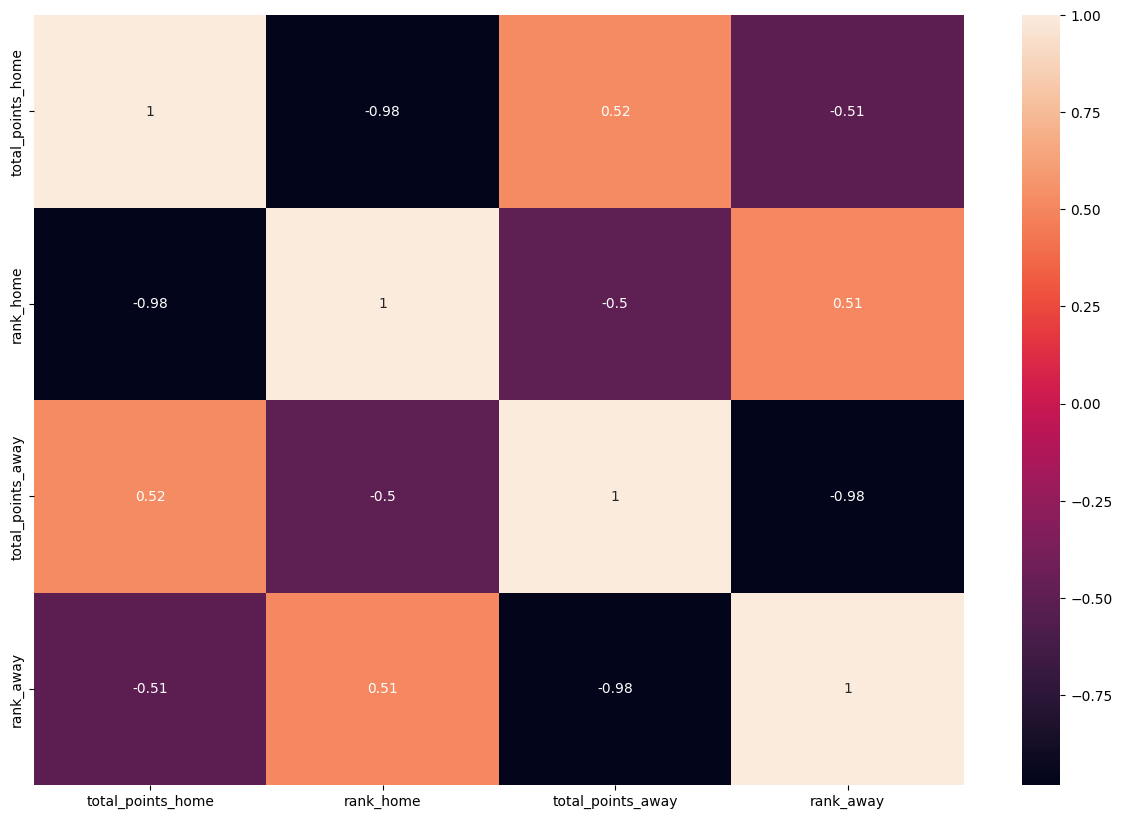

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
sns.heatmap(df[["total_points_home", "rank_home", "total_points_away", "rank_away"]].corr(), annot=True)
plt.show()

Começaremos criando variáveis que iram ajudar a criar outras variáveis: Diferença de Ranking, Diferença de Gols, pontos ganho no jogo pelo ranking do time (quanto maior o ranking, mais vale os pontos). Precisaremos criar as mesmas variáveis para os times da casa, quanto para o time de fora.

In [24]:
df["rank_dif"] = df["rank_home"] - df["rank_away"]
df["sg"] = df["home_score"] - df["away_score"]
df["points_home_by_rank"] = df["home_team_points"]/df["rank_away"]
df["points_away_by_rank"] = df["away_team_points"]/df["rank_home"]

Para melhorar a criação das features, vamos separar o dataset em dois: time de casa e timede fora, para podermos mensurar o valor dos jogos. Depois disso vamos juntá-los novamente, obtendo o dataset original. Somente para otimizar o processo de criação das features/variáveis.

In [25]:
home_team = df[["date", "home_team", "home_score", "away_score", "rank_home", "rank_away","rank_change_home", "total_points_home", "result", "rank_dif", "points_home_by_rank", "home_team_points", "country_classification_home"]]

away_team = df[["date", "away_team", "away_score", "home_score", "rank_away", "rank_home","rank_change_away", "total_points_away", "result", "rank_dif", "points_away_by_rank", "away_team_points", "country_classification_away"]]

In [26]:
home_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") for h in home_team.columns]

away_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") for a in away_team.columns]

In [27]:
home_team.head()

date     team  score  suf_score  rank  rank_suf  rank_change  \
0 2018-07-01   Russia    1.0        1.0  49.0       6.0        -12.0   
1 2018-07-01  Croatia    1.0        1.0  12.0      15.0         -6.0   
2 2018-07-02   Brazil    2.0        0.0   4.0      10.0          1.0   
3 2018-07-02  Belgium    3.0        2.0   5.0      41.0         -1.0   
4 2018-07-03   Sweden    1.0        0.0  21.0       8.0         -1.0   

   total_points  result  rank_dif  points_by_rank  team_points  \
0        1758.0       2      43.0        0.166667            1   
1        2036.0       2      -3.0        0.066667            1   
2        2160.0       0      -6.0        0.300000            3   
3        2124.0       0     -36.0        0.073171            3   
4        1955.0       0      13.0        0.375000            3   

  country_classification  
0               Classe S  
1               Classe S  
2               Classe S  
3               Classe S  
4               Classe S

In [28]:
team_stats = home_team.append(away_team)#.sort_values("date")

C:\Users\user\AppData\Local\Temp\ipykernel_7456\275322566.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  team_stats = home_team.append(away_team)#.sort_values("date")


In [29]:
team_stats.head()

date     team  score  suf_score  rank  rank_suf  rank_change  \
0 2018-07-01   Russia    1.0        1.0  49.0       6.0        -12.0   
1 2018-07-01  Croatia    1.0        1.0  12.0      15.0         -6.0   
2 2018-07-02   Brazil    2.0        0.0   4.0      10.0          1.0   
3 2018-07-02  Belgium    3.0        2.0   5.0      41.0         -1.0   
4 2018-07-03   Sweden    1.0        0.0  21.0       8.0         -1.0   

   total_points  result  rank_dif  points_by_rank  team_points  \
0        1758.0       2      43.0        0.166667            1   
1        2036.0       2      -3.0        0.066667            1   
2        2160.0       0      -6.0        0.300000            3   
3        2124.0       0     -36.0        0.073171            3   
4        1955.0       0      13.0        0.375000            3   

  country_classification  
0               Classe S  
1               Classe S  
2               Classe S  
3               Classe S  
4               Classe S

In [30]:
print(f'Para o feature engineering ficar mais simples, tinhamos um dataframe das partidas com {home_team.shape[0]} linhas e agora temos um dataframe com {team_stats.shape[0]}, sendo cada seleção uma linha, sem ser as partidas.')

Para o feature engineering ficar mais simples, tinhamos um dataframe das partidas com 3364 linhas e agora temos um dataframe com 6728, sendo cada seleção uma linha, sem ser as partidas.


In [31]:
#this column will be used to calculate features for simulation
team_stats_raw = team_stats.copy()

Agora, podemos criar algumas variáveis independentes, como:

- Média de gols da seleção no Ciclo da Copa do Mundo.
- Média de gols no time nos últimos 5 jogos.
- Média de gols sofridos do time nos últimos 5 jogos.
- Média de gols sofridos do time no Ciclo da Copa do Mundo.
- Média do Ranking da Fifa dos times enfrentados no Ciclo da Copa do Mundo.
- Média do Ranking da Fifa dos times adversários nos últimos 5 jogos.
- Pontuação FIFA conquistada no Ranking 
- Pontuação FIFA conquistada no Ranking nos últimos jogos.
- Média de pontuação conquistada no ciclo da copa
- Média de pontuação conquistada nos últimos 5 jogos
- Média de pontos conquistados pelo ranking do time adversário no ciclo da copa
- Média de pontos conquistados pelo ranking do time adversário nos últimos 5 jogos

In [32]:
team_stats

date              team  score  suf_score   rank  rank_suf  \
0    2018-07-01            Russia    1.0        1.0   49.0       6.0   
1    2018-07-01           Croatia    1.0        1.0   12.0      15.0   
2    2018-07-02            Brazil    2.0        0.0    4.0      10.0   
3    2018-07-02           Belgium    3.0        2.0    5.0      41.0   
4    2018-07-03            Sweden    1.0        0.0   21.0       8.0   
...         ...               ...    ...        ...    ...       ...   
3359 2022-09-27           Iceland    1.0        1.0   63.0      66.0   
3360 2022-09-27            Serbia    2.0        0.0   25.0      36.0   
3361 2022-09-27          Slovenia    1.0        1.0   65.0      20.0   
3362 2022-09-27            Cyprus    1.0        5.0  108.0     106.0   
3363 2022-09-27  Northern Ireland    1.0        3.0   58.0      49.0   

      rank_change  total_points  result  rank_dif  points_by_rank  \
0           -12.0       1758.00       2      43.0        0.166667   
1            -6.0       2036.00       2      -3.0        0.066667   
2             1.0       2160.00       0      -6.0        0.300000   
3            -1.0       2124.00       0     -36.0        0.073171   
4            -1.0       1955.00       0      13.0        0.375000   
...           ...           ...     ...       ...             ...   
3359          0.0       1379.61       2       3.0        0.015152   
3360          0.0       1549.53       1      11.0        0.083333   
3361          0.0       1372.48       2     -45.0        0.050000   
3362          1.0       1180.52       0      -2.0        0.000000   
3363          0.0       1399.10       0      -9.0        0.000000   

      team_points country_classification  
0               1               Classe S  
1               1               Classe S  
2               3               Classe S  
3               3               Classe S  
4               3               Classe S  
...           ...                    ...  
3359            1               Classe B  
3360            3               Classe A  
3361            1               Classe B  
3362            0               Classe C  
3363            0               Classe B  

[6728 rows x 13 columns]

In [33]:
team_stats.shape[0]/2

3364.0

In [34]:
team_stats.iloc[int(team_stats.shape[0]/2)]

date                      2018-07-01 00:00:00
team                                    Spain
score                                     1.0
suf_score                                 1.0
rank                                      6.0
rank_suf                                 49.0
rank_change                              -2.0
total_points                           2104.0
result                                      2
rank_dif                                 43.0
points_by_rank                       0.020408
team_points                                 1
country_classification               Classe S
Name: 0, dtype: object

In [35]:
team_stats.head

<bound method NDFrame.head of            date              team  score  suf_score   rank  rank_suf  \
0    2018-07-01            Russia    1.0        1.0   49.0       6.0   
1    2018-07-01           Croatia    1.0        1.0   12.0      15.0   
2    2018-07-02            Brazil    2.0        0.0    4.0      10.0   
3    2018-07-02           Belgium    3.0        2.0    5.0      41.0   
4    2018-07-03            Sweden    1.0        0.0   21.0       8.0   
...         ...               ...    ...        ...    ...       ...   
3359 2022-09-27           Iceland    1.0        1.0   63.0      66.0   
3360 2022-09-27            Serbia    2.0        0.0   25.0      36.0   
3361 2022-09-27          Slovenia    1.0        1.0   65.0      20.0   
3362 2022-09-27            Cyprus    1.0        5.0  108.0     106.0   
3363 2022-09-27  Northern Ireland    1.0        3.0   58.0      49.0   

      rank_change  total_points  result  rank_dif  points_by_rank  \
0           -12.0       1758.00     

In [36]:
for index, row in team_stats.iterrows():
    print(row)

date                      2018-07-01 00:00:00
team                                   Russia
score                                     1.0
suf_score                                 1.0
rank                                     49.0
rank_suf                                  6.0
rank_change                             -12.0
total_points                           1758.0
result                                      2
rank_dif                                 43.0
points_by_rank                       0.166667
team_points                                 1
country_classification               Classe S
Name: 0, dtype: object
date                      2018-07-01 00:00:00
team                                  Croatia
score                                     1.0
suf_score                                 1.0
rank                                     12.0
rank_suf                                 15.0
rank_change                              -6.0
total_points                           2036.0
result     

In [37]:
stats_val = []

for index, row in team_stats.iterrows():
    team = row["team"]
    date = row["date"]
    past_games = team_stats.query("team == @team & date < @date").sort_values(by=['date'], ascending=False)
    last5 = past_games.head(5)
    
    goals = past_games["score"].mean()
    goals_l5 = last5["score"].mean()
    
    goals_suf = past_games["suf_score"].mean()
    goals_suf_l5 = last5["suf_score"].mean()
    
    rank = past_games["rank_suf"].mean()
    rank_l5 = last5["rank_suf"].mean()
    
    if len(last5) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]#qtd de pontos ganhos
        points_l5 = last5["total_points"].values[0] - last5["total_points"].values[-1] 
    else:
        points = 0
        points_l5 = 0
        
    gp = past_games["team_points"].mean()
    gp_l5 = last5["team_points"].mean()
    
    gp_rank = past_games["points_by_rank"].mean()
    gp_rank_l5 = last5["points_by_rank"].mean()
    
    stats_val.append([goals, goals_l5, goals_suf, goals_suf_l5, rank, rank_l5, points, points_l5, gp, gp_l5, gp_rank, gp_rank_l5])

In [38]:
stats_cols = ["goals_mean", "goals_mean_l5", "goals_suf_mean", "goals_suf_mean_l5", "rank_mean", "rank_mean_l5", "points_mean", "points_mean_l5", "game_points_mean", "game_points_mean_l5", "game_points_rank_mean", "game_points_rank_mean_l5"]

stats_df = pd.DataFrame(stats_val, columns=stats_cols)

In [39]:
stats_df

goals_mean  goals_mean_l5  goals_suf_mean  goals_suf_mean_l5  rank_mean  \
0            NaN            NaN             NaN                NaN        NaN   
1            NaN            NaN             NaN                NaN        NaN   
2            NaN            NaN             NaN                NaN        NaN   
3            NaN            NaN             NaN                NaN        NaN   
4            NaN            NaN             NaN                NaN        NaN   
...          ...            ...             ...                ...        ...   
6723    1.100000            1.4        1.780000                1.0  58.660000   
6724    1.800000            2.2        1.111111                1.0  54.533333   
6725    1.380952            1.0        1.000000                1.8  76.357143   
6726    0.767442            0.6        1.767442                1.4  70.418605   
6727    1.023256            1.2        1.279070                1.4  57.906977   

      rank_mean_l5  points_mean  points_mean_l5  game_points_mean  \
0              NaN         0.00            0.00               NaN   
1              NaN         0.00            0.00               NaN   
2              NaN         0.00            0.00               NaN   
3              NaN         0.00            0.00               NaN   
4              NaN         0.00            0.00               NaN   
...            ...          ...             ...               ...   
6723          97.0       -91.39           -1.24          1.120000   
6724          42.0        90.53            2.00          1.866667   
6725          29.2       -19.52           -5.75          1.404762   
6726          63.8       -99.48           -5.57          0.767442   
6727          95.6       -92.90          -24.45          1.139535   

      game_points_mean_l5  game_points_rank_mean  game_points_rank_mean_l5  
0                     NaN                    NaN                       NaN  
1                     NaN                    NaN                       NaN  
2                     NaN                    NaN                       NaN  
3                     NaN                    NaN                       NaN  
4                     NaN                    NaN                       NaN  
...                   ...                    ...                       ...  
6723                  1.8               0.035917                  0.021851  
6724                  2.0               0.053327                  0.073887  
6725                  1.0               0.026035                  0.029545  
6726                  1.0               0.009687                  0.019652  
6727                  1.0               0.022315                  0.009470  

[6728 rows x 12 columns]

In [40]:
full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False)

In [41]:
full_df

date              team  score  suf_score   rank  rank_suf  \
0    2018-07-01            Russia    1.0        1.0   49.0       6.0   
1    2018-07-01           Croatia    1.0        1.0   12.0      15.0   
2    2018-07-02            Brazil    2.0        0.0    4.0      10.0   
3    2018-07-02           Belgium    3.0        2.0    5.0      41.0   
4    2018-07-03            Sweden    1.0        0.0   21.0       8.0   
...         ...               ...    ...        ...    ...       ...   
6723 2022-09-27           Iceland    1.0        1.0   63.0      66.0   
6724 2022-09-27            Serbia    2.0        0.0   25.0      36.0   
6725 2022-09-27          Slovenia    1.0        1.0   65.0      20.0   
6726 2022-09-27            Cyprus    1.0        5.0  108.0     106.0   
6727 2022-09-27  Northern Ireland    1.0        3.0   58.0      49.0   

      rank_change  total_points  result  rank_dif  ...  goals_suf_mean  \
0           -12.0       1758.00       2      43.0  ...             NaN   
1            -6.0       2036.00       2      -3.0  ...             NaN   
2             1.0       2160.00       0      -6.0  ...             NaN   
3            -1.0       2124.00       0     -36.0  ...             NaN   
4            -1.0       1955.00       0      13.0  ...             NaN   
...           ...           ...     ...       ...  ...             ...   
6723          0.0       1379.61       2       3.0  ...        1.780000   
6724          0.0       1549.53       1      11.0  ...        1.111111   
6725          0.0       1372.48       2     -45.0  ...        1.000000   
6726          1.0       1180.52       0      -2.0  ...        1.767442   
6727          0.0       1399.10       0      -9.0  ...        1.279070   

      goals_suf_mean_l5  rank_mean  rank_mean_l5  points_mean  points_mean_l5  \
0                   NaN        NaN           NaN         0.00            0.00   
1                   NaN        NaN           NaN         0.00            0.00   
2                   NaN        NaN           NaN         0.00            0.00   
3                   NaN        NaN           NaN         0.00            0.00   
4                   NaN        NaN           NaN         0.00            0.00   
...                 ...        ...           ...          ...             ...   
6723                1.0  58.660000          97.0       -91.39           -1.24   
6724                1.0  54.533333          42.0        90.53            2.00   
6725                1.8  76.357143          29.2       -19.52           -5.75   
6726                1.4  70.418605          63.8       -99.48           -5.57   
6727                1.4  57.906977          95.6       -92.90          -24.45   

      game_points_mean  game_points_mean_l5  game_points_rank_mean  \
0                  NaN                  NaN                    NaN   
1                  NaN                  NaN                    NaN   
2                  NaN                  NaN                    NaN   
3                  NaN                  NaN                    NaN   
4                  NaN                  NaN                    NaN   
...                ...                  ...                    ...   
6723          1.120000                  1.8               0.035917   
6724          1.866667                  2.0               0.053327   
6725          1.404762                  1.0               0.026035   
6726          0.767442                  1.0               0.009687   
6727          1.139535                  1.0               0.022315   

      game_points_rank_mean_l5  
0                          NaN  
1                          NaN  
2                          NaN  
3                          NaN  
4                          NaN  
...                        ...  
6723                  0.021851  
6724                  0.073887  
6725                  0.029545  
6726                  0.019652  
6727                  0.009470  

[6728 rows x 25 columns]

In [42]:
home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

The new columns:

In [43]:
home_team_stats.columns[-12:]

Index(['goals_mean', 'goals_mean_l5', 'goals_suf_mean', 'goals_suf_mean_l5',
       'rank_mean', 'rank_mean_l5', 'points_mean', 'points_mean_l5',
       'game_points_mean', 'game_points_mean_l5', 'game_points_rank_mean',
       'game_points_rank_mean_l5'],
      dtype='object')

In [44]:
home_team_stats = home_team_stats[home_team_stats.columns[-12:]]
away_team_stats = away_team_stats[away_team_stats.columns[-12:]]

In [45]:
home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

Para unirmos os dataframes mas sabermos de qual seleção está se referindo o DataFrams, iremos adicionar os sufixos "home_" e "away_"

In [46]:
match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [47]:
full_df = pd.concat([df, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [48]:
full_df.tail(5)

date home_team         away_team  home_score  away_score  \
3359 2022-09-27   Albania           Iceland         1.0         1.0   
3360 2022-09-27    Norway            Serbia         0.0         2.0   
3361 2022-09-27    Sweden          Slovenia         1.0         1.0   
3362 2022-09-27    Kosovo            Cyprus         5.0         1.0   
3363 2022-09-27    Greece  Northern Ireland         3.0         1.0   

               tournament       city  country  neutral  total_points_home  \
3359  UEFA Nations League     Tirana  Albania    False            1361.81   
3360  UEFA Nations League       Oslo   Norway    False            1488.57   
3361  UEFA Nations League  Stockholm   Sweden    False            1563.44   
3362  UEFA Nations League   Pristina   Kosovo    False            1183.90   
3363  UEFA Nations League     Athens   Greece    False            1441.45   

      ...  away_goals_suf_mean  away_goals_suf_mean_l5  away_rank_mean  \
3359  ...             1.780000                     1.0       58.660000   
3360  ...             1.111111                     1.0       54.533333   
3361  ...             1.000000                     1.8       76.357143   
3362  ...             1.767442                     1.4       70.418605   
3363  ...             1.279070                     1.4       57.906977   

     away_rank_mean_l5  away_points_mean  away_points_mean_l5  \
3359              97.0            -91.39                -1.24   
3360              42.0             90.53                 2.00   
3361              29.2            -19.52                -5.75   
3362              63.8            -99.48                -5.57   
3363              95.6            -92.90               -24.45   

      away_game_points_mean  away_game_points_mean_l5  \
3359               1.120000                       1.8   
3360               1.866667                       2.0   
3361               1.404762                       1.0   
3362               0.767442                       1.0   
3363               1.139535                       1.0   

     away_game_points_rank_mean  away_game_points_rank_mean_l5  
3359                   0.035917                       0.021851  
3360                   0.053327                       0.073887  
3361                   0.026035                       0.029545  
3362                   0.009687                       0.019652  
3363                   0.022315                       0.009470  

[5 rows x 50 columns]

In [49]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'country_classification_home', 'total_points_away',
       'previous_points_away', 'rank_away', 'rank_change_away',
       'country_classification_away', 'result', 'home_team_points',
       'away_team_points', 'rank_dif', 'sg', 'points_home_by_rank',
       'points_away_by_rank', 'home_goals_mean', 'home_goals_mean_l5',
       'home_goals_suf_mean', 'home_goals_suf_mean_l5', 'home_rank_mean',
       'home_rank_mean_l5', 'home_points_mean', 'home_points_mean_l5',
       'home_game_points_mean', 'home_game_points_mean_l5',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5',
       'away_goals_mean', 'away_goals_mean_l5', 'away_goals_suf_mean',
       'away_goals_suf_mean_l5', 'away_rank_mean', 'away_rank_mean_l5',
       'away_points_mean', 'away_points_mean_l5

Quantificando a importância do jogo: simplesmente dizendo se o jogo é amistoso ou não.

In [50]:
def find_friendly(x):
    if x == "Friendly":
        return 1
    else: return 0

full_df["is_friendly"] = full_df["tournament"].apply(lambda x: find_friendly(x)) 

In [51]:
full_df = pd.get_dummies(full_df, columns=["is_friendly"])

In [52]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'country_classification_home', 'total_points_away',
       'previous_points_away', 'rank_away', 'rank_change_away',
       'country_classification_away', 'result', 'home_team_points',
       'away_team_points', 'rank_dif', 'sg', 'points_home_by_rank',
       'points_away_by_rank', 'home_goals_mean', 'home_goals_mean_l5',
       'home_goals_suf_mean', 'home_goals_suf_mean_l5', 'home_rank_mean',
       'home_rank_mean_l5', 'home_points_mean', 'home_points_mean_l5',
       'home_game_points_mean', 'home_game_points_mean_l5',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5',
       'away_goals_mean', 'away_goals_mean_l5', 'away_goals_suf_mean',
       'away_goals_suf_mean_l5', 'away_rank_mean', 'away_rank_mean_l5',
       'away_points_mean', 'away_points_mean_l5

And, after that, we select only columns that will help in Features' analysis.

Vamos retirar as seguintes variáveis:

tournament, city, country, neutral, total_points_home, previous_points_home, total_points_away, previous_points_away, home_team_points, away_team_points, sg, points_home_by_rank, points_away_by_rank, rank_change_home e rank_change_away

In [53]:
base_df = full_df[["date", "home_team", "away_team", "rank_home", "rank_away","home_score", "away_score","result", "rank_dif", "rank_change_home", "rank_change_away", 'home_goals_mean',
        'country_classification_home', 'country_classification_away',
       'home_goals_mean_l5', 'home_goals_suf_mean', 'home_goals_suf_mean_l5',
       'home_rank_mean', 'home_rank_mean_l5', 'home_points_mean',
       'home_points_mean_l5', 'away_goals_mean', 'away_goals_mean_l5',
       'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_rank_mean',
       'away_rank_mean_l5', 'away_points_mean', 'away_points_mean_l5','home_game_points_mean', 'home_game_points_mean_l5',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5','away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5', 
       'is_friendly_0', 'is_friendly_1']]

base_df.tail()

date home_team         away_team  rank_home  rank_away  home_score  \
3359 2022-09-27   Albania           Iceland       66.0       63.0         1.0   
3360 2022-09-27    Norway            Serbia       36.0       25.0         0.0   
3361 2022-09-27    Sweden          Slovenia       20.0       65.0         1.0   
3362 2022-09-27    Kosovo            Cyprus      106.0      108.0         5.0   
3363 2022-09-27    Greece  Northern Ireland       49.0       58.0         3.0   

      away_score  result  rank_dif  rank_change_home  ...  \
3359         1.0       2       3.0               0.0  ...   
3360         2.0       1      11.0               0.0  ...   
3361         1.0       2     -45.0               0.0  ...   
3362         1.0       0      -2.0               0.0  ...   
3363         1.0       0      -9.0               1.0  ...   

      home_game_points_mean  home_game_points_mean_l5  \
3359               1.365854                       0.6   
3360               1.833333                       2.0   
3361               1.603774                       0.6   
3362               1.326087                       1.2   
3363               1.590909                       2.4   

     home_game_points_rank_mean home_game_points_rank_mean_l5  \
3359                   0.019776                      0.007318   
3360                   0.041984                      0.090235   
3361                   0.053765                      0.009231   
3362                   0.018478                      0.016825   
3363                   0.050090                      0.028040   

      away_game_points_mean  away_game_points_mean_l5  \
3359               1.120000                       1.8   
3360               1.866667                       2.0   
3361               1.404762                       1.0   
3362               0.767442                       1.0   
3363               1.139535                       1.0   

      away_game_points_rank_mean  away_game_points_rank_mean_l5  \
3359                    0.035917                       0.021851   
3360                    0.053327                       0.073887   
3361                    0.026035                       0.029545   
3362                    0.009687                       0.019652   
3363                    0.022315                       0.009470   

      is_friendly_0  is_friendly_1  
3359              1              0  
3360              1              0  
3361              1              0  
3362              1              0  
3363              1              0  

[5 rows x 39 columns]

In [54]:
base_df.isna().sum()

date                               0
home_team                          0
away_team                          0
rank_home                          0
rank_away                          0
home_score                         0
away_score                         0
result                             0
rank_dif                           0
rank_change_home                   0
rank_change_away                   0
home_goals_mean                  105
country_classification_home        0
country_classification_away        0
home_goals_mean_l5               105
home_goals_suf_mean              105
home_goals_suf_mean_l5           105
home_rank_mean                   105
home_rank_mean_l5                105
home_points_mean                   0
home_points_mean_l5                0
away_goals_mean                   96
away_goals_mean_l5                96
away_goals_suf_mean               96
away_goals_suf_mean_l5            96
away_rank_mean                    96
away_rank_mean_l5                 96
a

The games with NA are the ones who mean could not be calculated (games from the beginning of the dataset). Those will be dropped.

In [55]:
base_df_no_fg = base_df.dropna()

# Data Analysis

Now, we need to analyze all features that were created and check if they have predictive power. Also, if they don't have, we need to create some that have, like differences of home and away teams. To analyze the predictive power, I'll assign draw games as a lose of the home team and will create a binary problem. 

In [56]:
df = base_df_no_fg

In [57]:
df = df.query("result != 2")

In [58]:
df['result'].value_counts()

0    1561
1     914
Name: result, dtype: int64

In [152]:
def no_draw(x):
    if x == 2:
        return 1
    else:
        return x
    
df["target"] = df["result"].apply(lambda x: no_draw(x))

C:\Users\user\AppData\Local\Temp\ipykernel_18204\1906038641.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["target"] = df["result"].apply(lambda x: no_draw(x))


Analysis that will be made:

- Violin and boxplot to analyze if the features have different distributions according to the target
- Scatter plots to analyze correlations

In [153]:
data1 = df[list(df.columns[8:20].values) + ["target"]]
data2 = df[df.columns[20:]]

In [154]:
scaled = (data1[:-1] - data1[:-1].mean()) / data1[:-1].std()
scaled["target"] = data1["target"]
violin1 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

scaled = (data2[:-1] - data2[:-1].mean()) / data2[:-1].std()
scaled["target"] = data2["target"]
violin2 = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

C:\Users\user\AppData\Local\Temp\ipykernel_18204\2229707586.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  scaled = (data1[:-1] - data1[:-1].mean()) / data1[:-1].std()
C:\Users\user\AppData\Local\Temp\ipykernel_18204\2229707586.py:1: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  scaled = (data1[:-1] - data1[:-1].mean()) / data1[:-1].std()


In [155]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin1,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

ValueError: object arrays are not supported

<Figure size 1500x1000 with 0 Axes>

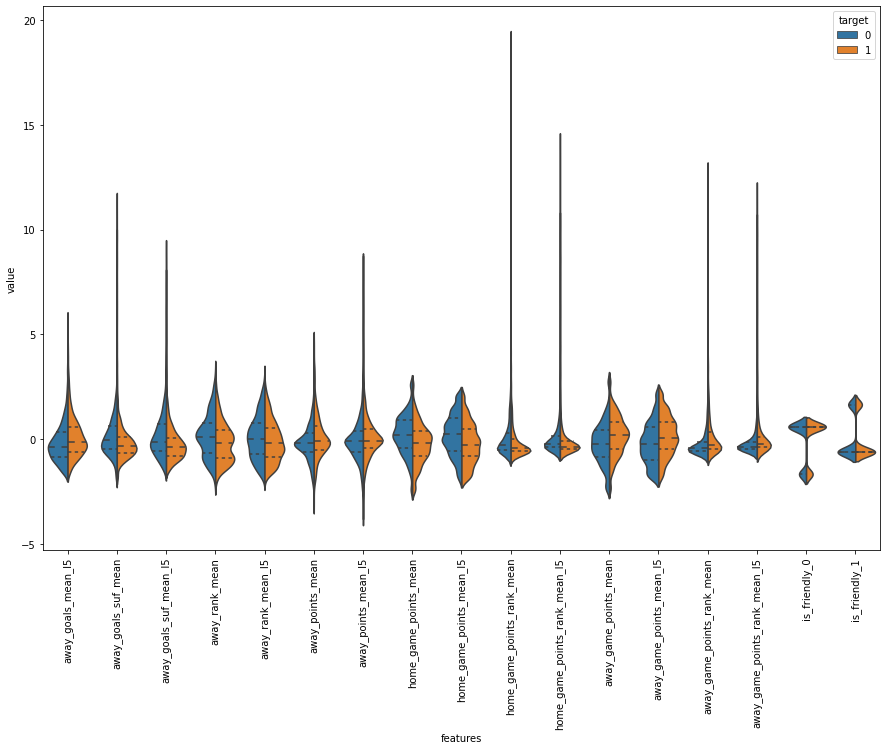

In [ ]:
plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin2,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

With the plots, we find that rank difference is the only good separator of the data. But, we can create features that get the differences between home and away team and analyze if they are good separating the data.

In [156]:
dif = df.copy()
dif.loc[:, "goals_dif"] = dif["home_goals_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_mean_l5"]
dif.loc[:, "goals_suf_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_suf_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_made_suf_dif"] = dif["home_goals_mean"] - dif["away_goals_suf_mean"]
dif.loc[:, "goals_made_suf_dif_l5"] = dif["home_goals_mean_l5"] - dif["away_goals_suf_mean_l5"]
dif.loc[:, "goals_suf_made_dif"] = dif["home_goals_suf_mean"] - dif["away_goals_mean"]
dif.loc[:, "goals_suf_made_dif_l5"] = dif["home_goals_suf_mean_l5"] - dif["away_goals_mean_l5"]

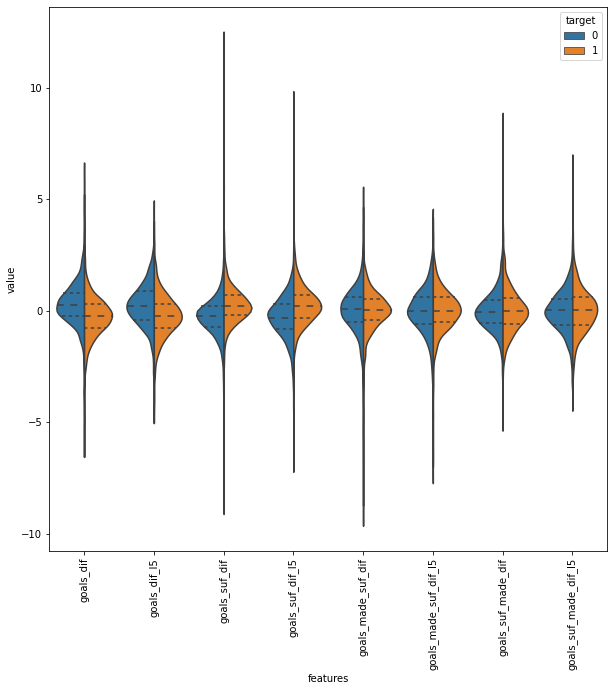

In [ ]:
data_difs = dif.iloc[:, -8:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

With that plot, we see that goal differences are good separator, and goals suffered difference too. Differences between goals made and goals suffered of the teams are not very good separators.

Now, we have 5 features:

- rank_dif
- goals_dif
- goals_dif_l5
- goals_suf_dif
- goals_suf_dif_l5

We can create other features, like differences of points made, differences of points made by rank faced and differences of rank faced.

In [157]:
dif.loc[:, "dif_points"] = dif["home_game_points_mean"] - dif["away_game_points_mean"]
dif.loc[:, "dif_points_l5"] = dif["home_game_points_mean_l5"] - dif["away_game_points_mean_l5"]
dif.loc[:, "dif_points_rank"] = dif["home_game_points_rank_mean"] - dif["away_game_points_rank_mean"]
dif.loc[:, "dif_points_rank_l5"] = dif["home_game_points_rank_mean_l5"] - dif["away_game_points_rank_mean_l5"]

In [158]:
dif.loc[:, "dif_rank_agst"] = dif["home_rank_mean"] - dif["away_rank_mean"]
dif.loc[:, "dif_rank_agst_l5"] = dif["home_rank_mean_l5"] - dif["away_rank_mean_l5"]

Also, we can calculate goals made and suffered by rank, and check this difference.

In [159]:
dif.loc[:, "goals_per_ranking_dif"] = (dif["home_goals_mean"] / dif["home_rank_mean"]) - (dif["away_goals_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif"] = (dif["home_goals_suf_mean"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_dif_l5"] = (dif["home_goals_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_mean_l5"] / dif["away_rank_mean"])
dif.loc[:, "goals_per_ranking_suf_dif_l5"] = (dif["home_goals_suf_mean_l5"] / dif["home_rank_mean"]) - (dif["away_goals_suf_mean_l5"] / dif["away_rank_mean"])

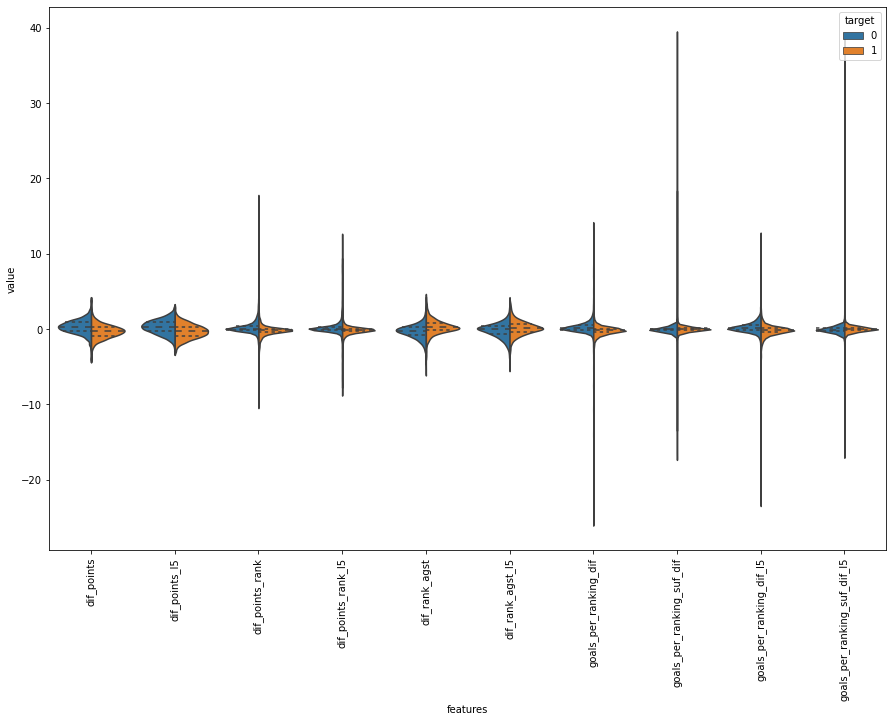

In [ ]:
data_difs = dif.iloc[:, -10:]
scaled = (data_difs - data_difs.mean()) / data_difs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

Due to the low values, the violin plot was not a good choice to analyze if features are really separating the data in this case. We will see then the boxplot:

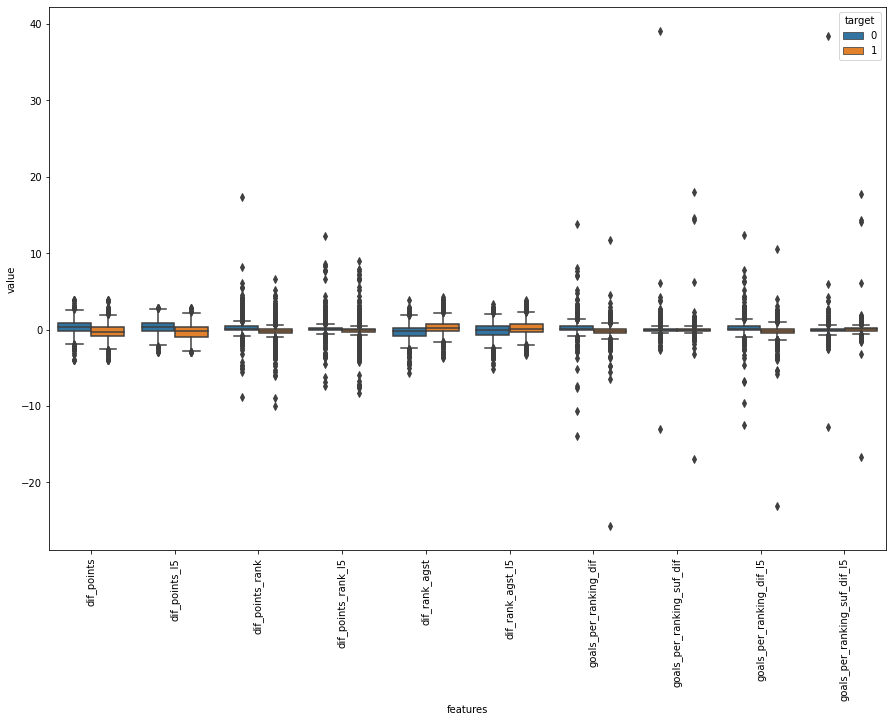

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(x="features", y="value", hue="target", data=violin)
plt.xticks(rotation=90)
plt.show()

Difference of points (full and last 5 games), difference of points by ranking faced (full and last 5 games) and difference of rank faced (full and last 5 games) are good features. Also, some of the generated features have very similar distributions which will be analyzed using scatterplots.

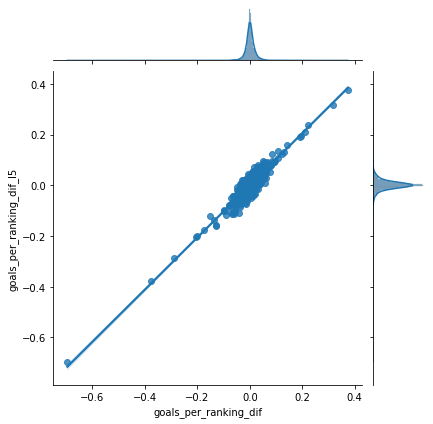

In [ ]:
sns.jointplot(data = data_difs, x = 'goals_per_ranking_dif', y = 'goals_per_ranking_dif_l5', kind="reg")
plt.show()

Goals difference by ranking faced and its last 5 games version has very similar distributions. So, we will use only the full version (goals_per_ranking_dif).

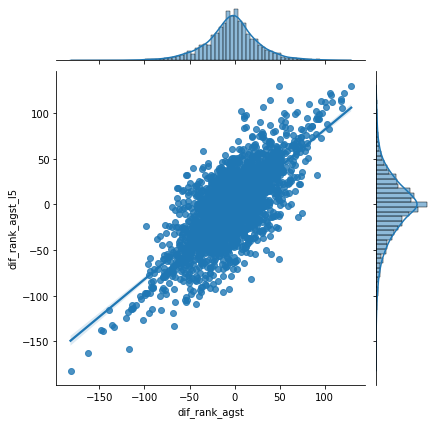

In [ ]:
sns.jointplot(data = data_difs, x = 'dif_rank_agst', y = 'dif_rank_agst_l5', kind="reg")
plt.show()

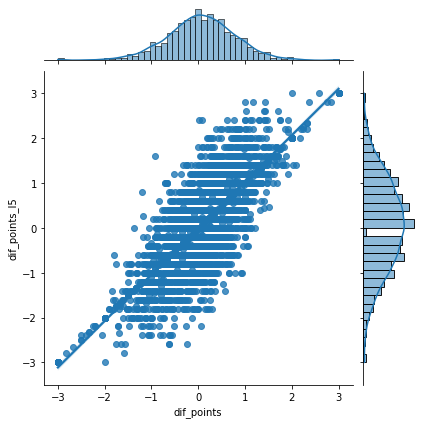

In [ ]:
sns.jointplot(data = data_difs, x = 'dif_points', y = 'dif_points_l5', kind="reg")
plt.show()

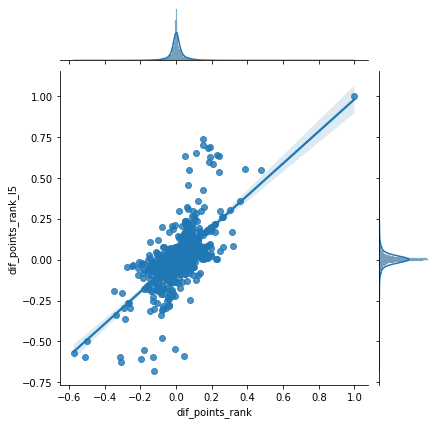

In [ ]:
sns.jointplot(data = data_difs, x = 'dif_points_rank', y = 'dif_points_rank_l5', kind="reg")
plt.show()

For the differences of rank faced, game points by rank faced and mean game points by rank faced, the two versions (full and 5 games) are not so similar. So, we will use both.

Based on that, final features are:


- rank_dif
- goals_dif
- goals_dif_l5
- goals_suf_dif
- goals_suf_dif_l5
- dif_rank_agst
- dif_rank_agst_l5
- goals_per_ranking_dif
- dif_points_rank
- dif_points_rank_l5
- is_friendly

In [59]:
def create_db(df):
    columns = ["home_team", "away_team", "result", "rank_dif", "home_goals_mean", "home_rank_mean", "away_goals_mean", "away_rank_mean", "home_rank_mean_l5", "away_rank_mean_l5", "home_goals_suf_mean", "away_goals_suf_mean", "home_goals_mean_l5", "away_goals_mean_l5", "home_goals_suf_mean_l5", "away_goals_suf_mean_l5", "home_game_points_rank_mean", "home_game_points_rank_mean_l5", "away_game_points_rank_mean", "away_game_points_rank_mean_l5","is_friendly_0", "is_friendly_1"]
    
    base = df.loc[:, columns]
    base.loc[:, "goals_dif"] = base["home_goals_mean"] - base["away_goals_mean"]
    base.loc[:, "goals_dif_l5"] = base["home_goals_mean_l5"] - base["away_goals_mean_l5"]
    base.loc[:, "goals_suf_dif"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
    base.loc[:, "goals_suf_dif_l5"] = base["home_goals_suf_mean_l5"] - base["away_goals_suf_mean_l5"]
    base.loc[:, "goals_per_ranking_dif"] = (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])
    base.loc[:, "dif_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
    base.loc[:, "dif_rank_agst_l5"] = base["home_rank_mean_l5"] - base["away_rank_mean_l5"]
    base.loc[:, "dif_points_rank"] = base["home_game_points_rank_mean"] - base["away_game_points_rank_mean"]
    base.loc[:, "dif_points_rank_l5"] = base["home_game_points_rank_mean_l5"] - base["away_game_points_rank_mean_l5"]
    
    model_df = base[["home_team", "away_team", "result", "rank_dif", "goals_dif", "goals_dif_l5", "goals_suf_dif", "goals_suf_dif_l5", "goals_per_ranking_dif", "dif_rank_agst", "dif_rank_agst_l5", "dif_points_rank", "dif_points_rank_l5", "is_friendly_0", "is_friendly_1"]]
    return model_df

# Onde era target coloquei result

In [60]:
model_db = create_db(df)

In [61]:
model_db

home_team         away_team  result  rank_dif  goals_dif  \
8                  Brazil           Belgium       1      -1.0  -1.000000   
9                  Sweden           England       1      14.0   0.000000   
11                 France           Belgium       0      -3.0  -0.500000   
12                Croatia           England       0       5.0   0.000000   
13                Belgium           England       0      -2.0   0.333333   
...                   ...               ...     ...       ...        ...   
3356          Switzerland    Czech Republic       0     -16.0   0.358418   
3357  Republic of Ireland           Armenia       0     -45.0  -0.181872   
3360               Norway            Serbia       1      11.0  -0.038095   
3362               Kosovo            Cyprus       0      -2.0   0.667341   
3363               Greece  Northern Ireland       0      -9.0   0.067653   

      goals_dif_l5  goals_suf_dif  goals_suf_dif_l5  goals_per_ranking_dif  \
8        -1.000000      -2.000000         -2.000000               0.126829   
9         0.000000      -1.000000         -1.000000               0.066176   
11       -0.500000      -1.500000         -1.500000               0.031746   
12        0.000000       1.000000          1.000000              -0.032072   
13        0.333333       0.333333          0.333333               0.026383   
...            ...            ...               ...                    ...   
3356      0.000000      -0.231718         -0.600000               0.008882   
3357      0.600000      -1.293381         -1.800000               0.002826   
3360     -0.800000      -0.230159          0.000000              -0.005282   
3362      0.600000      -0.463094          0.000000               0.007625   
3363      0.200000      -0.369979         -1.200000              -0.002915   

      dif_rank_agst  dif_rank_agst_l5  dif_points_rank  dif_points_rank_l5  \
8        -31.000000             -31.0         0.226829            0.226829   
9         -9.000000              -9.0         0.316176            0.316176   
11        -8.500000              -8.5        -0.197300           -0.197300   
12        13.000000              13.0        -0.057303           -0.057303   
13        -1.000000              -1.0         0.207163            0.207163   
...             ...               ...              ...                 ...   
3356      -0.212160               3.4         0.064932            0.103571   
3357     -21.721527              10.2         0.035339            0.010026   
3360       9.014286              -3.4        -0.011343            0.016348   
3362       7.037917               1.6         0.008791           -0.002827   
3363      16.024841               0.6         0.027775            0.018570   

      is_friendly_0  is_friendly_1  
8                 1              0  
9                 1              0  
11                1              0  
12                1              0  
13                1              0  
...             ...            ...  
3356              1              0  
3357              1              0  
3360              1              0  
3362              1              0  
3363              1              0  

[2475 rows x 15 columns]

# The model

Now that we have a database ready and with columns with predictive power, we can start our modelling. 

Two models will be tested: Random Forest and Gradient Boosting. The selected will be the one with best recall.

In [163]:
factor_result = pd.factorize(model_db['result'])

In [164]:
model_db['result'] = factor_result[0]
definitions = factor_result[1]

In [62]:
X = model_db.iloc[:, 3:]
y = model_db[["result"]]

In [63]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)

In [65]:
gb = GradientBoostingClassifier(random_state=5)

params = {"learning_rate": [0.01, 0.1, 0.5],
            "min_samples_split": [5, 10],
            "min_samples_leaf": [3, 5],
            "max_depth":[3,5,10],
            "max_features":["sqrt"],
            "n_estimators":[100, 200]
         } 

gb_cv = GridSearchCV(gb, params, cv = 3, n_jobs = -1, verbose = False)

In [66]:
print(gb_cv)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=5),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200]},
             verbose=False)


In [67]:
gb_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=5),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200]},
             verbose=False)

In [68]:
gb = gb_cv.best_estimator_

In [97]:
gb

GradientBoostingClassifier(learning_rate=0.01, max_features='sqrt',
                           min_samples_leaf=3, min_samples_split=10,
                           n_estimators=200, random_state=5)

In [83]:
print(len(y_pred), len(y_test))

645 645


In [89]:
np.ravel(y_test)

array([0, 1, 0, 1, 0, 0, 2, 2, 2, 2, 0, 0, 1, 2, 1, 2, 2, 2, 2, 1, 0, 2,
       2, 0, 2, 2, 2, 2, 0, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 1, 2, 0, 1, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 1, 2, 1, 0, 1,
       0, 2, 2, 2, 1, 1, 2, 0, 2, 0, 2, 1, 0, 2, 0, 2, 1, 0, 0, 0, 1, 1,
       2, 1, 2, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 1, 2, 0, 0, 2, 0, 0, 1,
       2, 2, 2, 0, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 0, 1, 0, 2, 2,
       0, 2, 0, 1, 1, 2, 2, 1, 1, 0, 0, 1, 0, 2, 0, 1, 1, 2, 2, 0, 2, 0,
       2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 1, 2, 2, 1, 2, 2, 2, 2,
       2, 0, 1, 2, 1, 0, 0, 0, 0, 1, 1, 2, 0, 0, 1, 0, 2, 2, 1, 0, 1, 2,
       0, 0, 1, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 1, 0, 1, 1, 2, 2, 2,
       2, 2, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 2, 0, 2, 1, 2, 2, 1, 0, 2, 2,
       0, 0, 1, 2, 0, 1, 1, 1, 2, 2, 0, 0, 2, 2, 1, 2, 1, 0, 2, 1, 2, 2,
       1, 2, 2, 0, 1, 1, 2, 0, 0, 2, 0, 2, 0, 2, 1,

In [70]:
# Predicting the Test set results
y_pred = gb.predict(X_test)
#Reverse factorize (converting y_pred from 0s,1s and 2s to Iris-setosa, Iris-versicolor and Iris-virginica
# reversefactor = dict(zip(range(3),definitions))
# y_test = np.vectorize(reversefactor.get)(y_test)
# y_pred = np.vectorize(reversefactor.get)(y_pred)
# Making the Confusion Matrix
pd.crosstab(np.ravel(y_test), y_pred)

e:\repos\FIFA_WC_22_Predictions\venv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


col_0    0    1
row_0          
0      271   36
1       74  114

In [75]:
params_rf = {"max_depth": [20],
                "min_samples_split": [10],
                "max_leaf_nodes": [175],
                "min_samples_leaf": [5],
                "n_estimators": [250],
                 "max_features": ["sqrt"],
                }

rf = RandomForestClassifier(random_state=1)

rf_cv = GridSearchCV(rf, params_rf, cv = 3, n_jobs = -1, verbose = False)

rf_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [20], 'max_features': ['sqrt'],
                         'max_leaf_nodes': [175], 'min_samples_leaf': [5],
                         'min_samples_split': [10], 'n_estimators': [250]},
             verbose=False)

In [76]:
rf = rf_cv.best_estimator_

In [77]:
# Predicting the Test set results
y_pred = rf.predict(X_test)
#Reverse factorize (converting y_pred from 0s,1s and 2s to Iris-setosa, Iris-versicolor and Iris-virginica
# reversefactor = dict(zip(range(3),definitions))
# y_test = np.vectorize(reversefactor.get)(y_test)
# y_pred = np.vectorize(reversefactor.get)(y_pred)
# Making the Confusion Matrix
pd.crosstab(np.ravel(y_test), y_pred)

e:\repos\FIFA_WC_22_Predictions\venv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


col_0    0    1
row_0          
0      264   43
1       71  117

In [73]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [71]:
def analyze(model):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test.values)[:,1]) #test AUC
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(X_train.values)[:,1]) #train AUC
    plt.plot(fpr_train, tpr_train, label="train")
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test.values)[:,1])
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train.values)[:,1])
    plt.legend()
    plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
    plt.show()
    
    plt.figure(figsize=(15, 10))
    cm = confusion_matrix(y_test, model.predict(X_test.values))
    sns.heatmap(cm, annot=True, fmt="d")

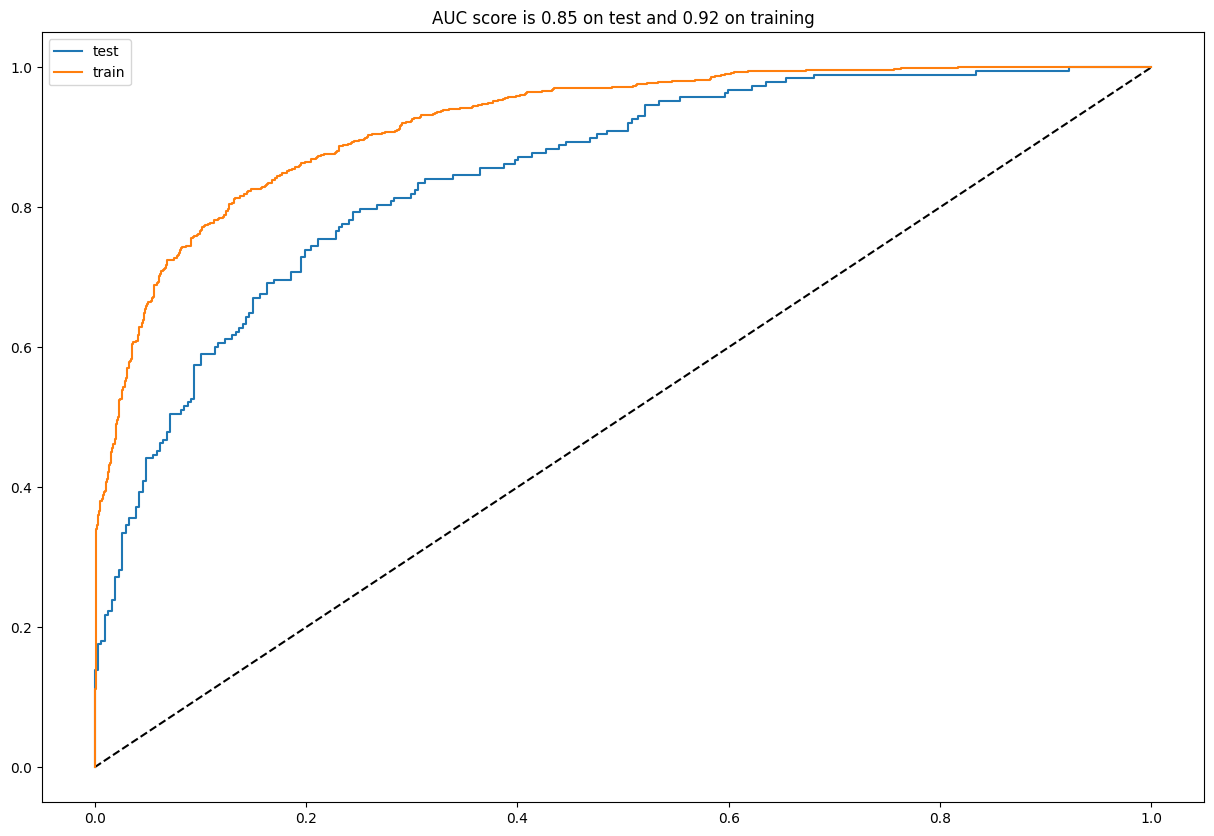

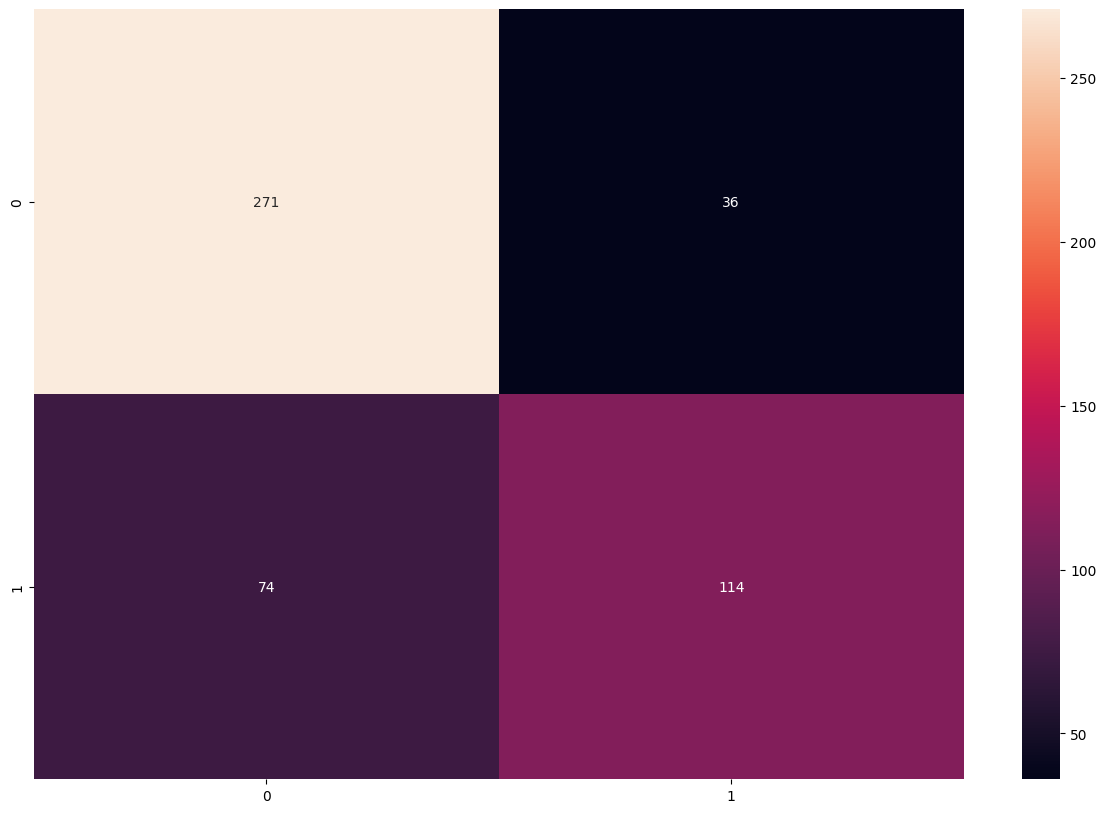

In [74]:
analyze(gb)

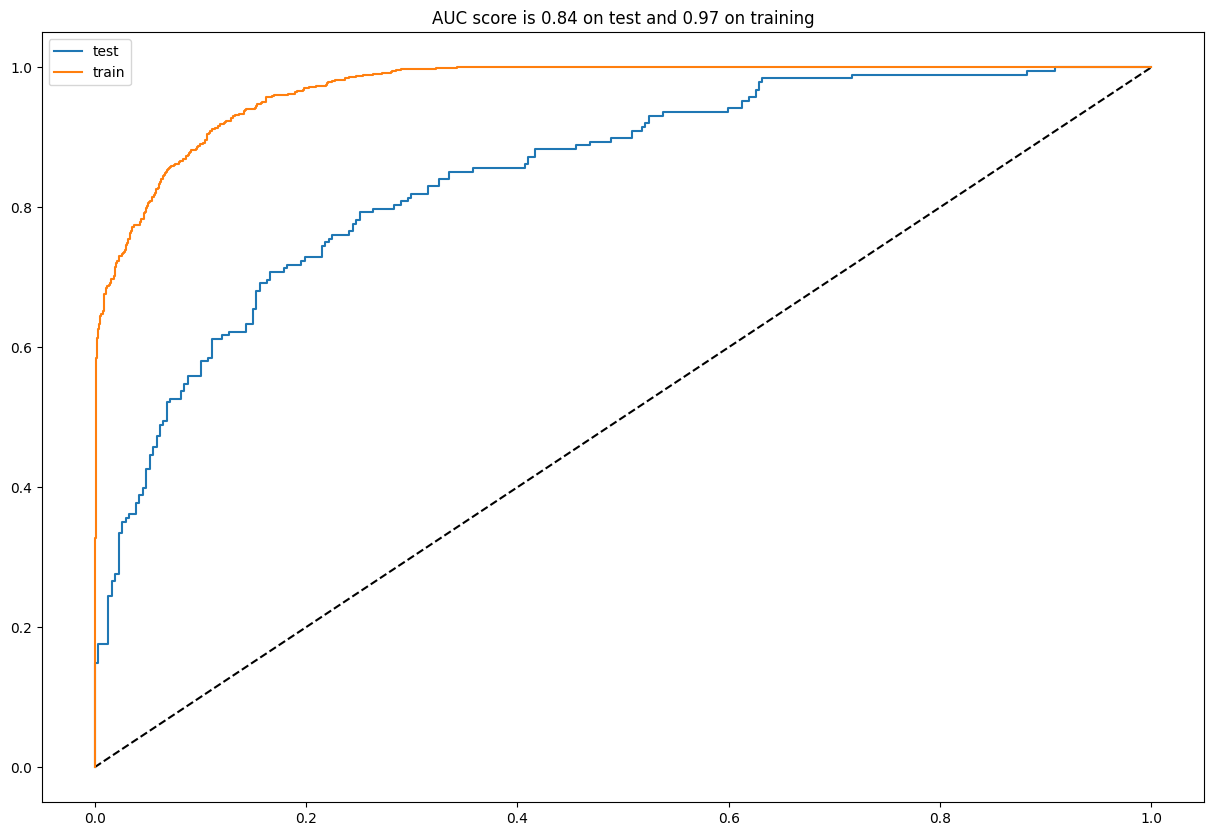

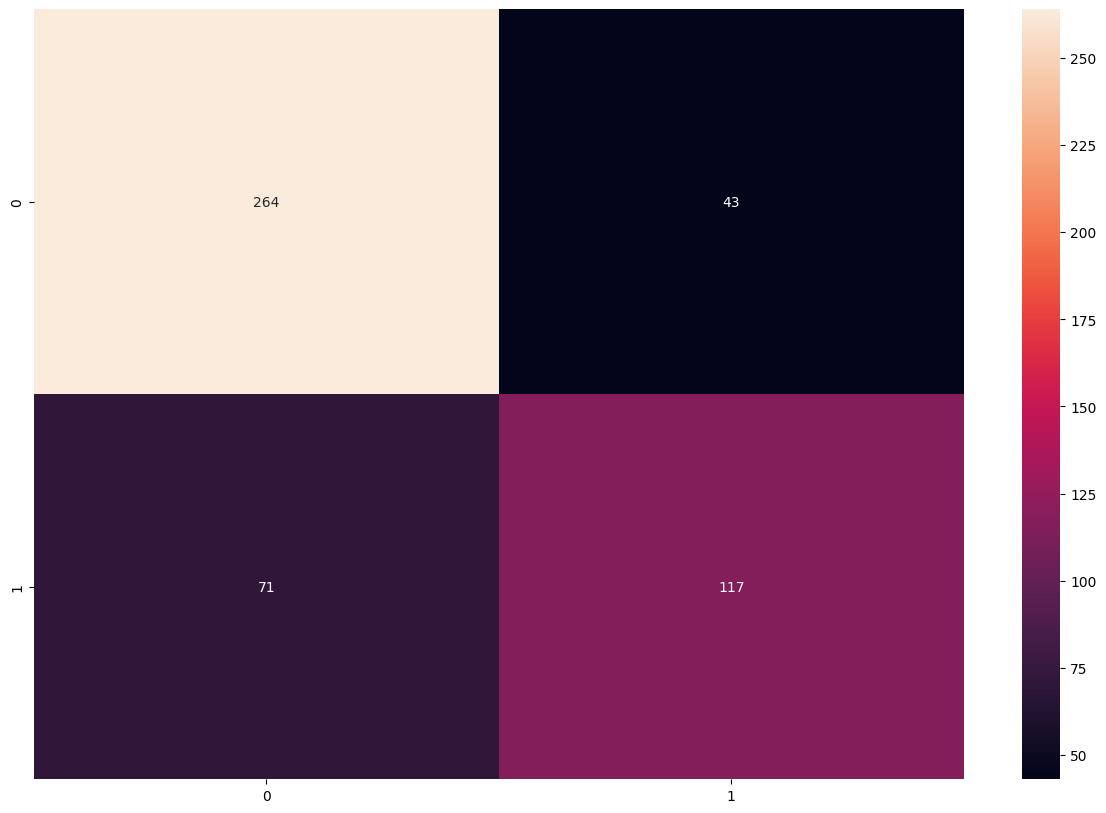

In [78]:
analyze(rf)

The Random Forest model is a little bit better but seems to underfit. So, we will use the Gradient Boosting Model.

In [130]:
from operator import itemgetter

# WC Simulation

The first thing is to create FIFA World Cup games. To do this, I'll get in the wikipedia the teams and group phase matches.

In [79]:
import lxml

In [88]:
dfs = pd.read_html(r"https://en.wikipedia.org/wiki/2022_FIFA_World_Cup#Teams")

In [124]:
dfs[12]

Pos  \
0    1   
1    2   
2    3   
3    4   

  Team.mw-parser-output .navbar{display:inline;font-size:88%;font-weight:normal}.mw-parser-output .navbar-collapse{float:left;text-align:left}.mw-parser-output .navbar-boxtext{word-spacing:0}.mw-parser-output .navbar ul{display:inline-block;white-space:nowrap;line-height:inherit}.mw-parser-output .navbar-brackets::before{margin-right:-0.125em;content:"[ "}.mw-parser-output .navbar-brackets::after{margin-left:-0.125em;content:" ]"}.mw-parser-output .navbar li{word-spacing:-0.125em}.mw-parser-output .navbar a>span,.mw-parser-output .navbar a>abbr{text-decoration:inherit}.mw-parser-output .navbar-mini abbr{font-variant:small-caps;border-bottom:none;text-decoration:none;cursor:inherit}.mw-parser-output .navbar-ct-full{font-size:114%;margin:0 7em}.mw-parser-output .navbar-ct-mini{font-size:114%;margin:0 4em}vte  \
0                                          Qatar (H)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
1                                            Ecuador                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
2                                            Senegal                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
3                                        Netherlands                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [118]:
[[a.split(" ")[0]] for a in list(dfs[12].iloc[:, 1].values)]

[['Qatar'], ['Ecuador'], ['Senegal'], ['Netherlands']]

In [121]:
matches = []
groups = ["A", "B", "C", "D", "E", "F", "G", "H"]
group_count = 0 

table = {}
#TABLE -> TEAM, POINTS, WIN PROBS (CRITERIO DE DESEMPATE)
table[groups[group_count]] = [[a.split(" ")[0], 0, []] for a in list(dfs[12].iloc[:, 1].values)]

In [120]:
table

{'A': [['England', 0, []],
  ['Iran', 0, []],
  ['United', 0, []],
  ['Wales', 0, []]]}

In [125]:
for i in range(13, 68, 1):
    if len(dfs[i].columns) == 3:
        team_1 = dfs[i].columns.values[0]
        team_2 = dfs[i].columns.values[-1]
        
        matches.append((groups[group_count], team_1, team_2))
    else:
        group_count+=1
        table[groups[group_count]] = [[a, 0, []] for a in list(dfs[i].iloc[:, 1].values)]

In [75]:
table

{'A': [['Qatar', 0, []],
  ['Ecuador', 0, []],
  ['Senegal', 0, []],
  ['Netherlands', 0, []]],
 'B': [['England', 0, []],
  ['Iran', 0, []],
  ['United States', 0, []],
  ['Wales', 0, []]],
 'C': [['Argentina', 0, []],
  ['Saudi Arabia', 0, []],
  ['Mexico', 0, []],
  ['Poland', 0, []]],
 'D': [['France', 0, []],
  ['Australia', 0, []],
  ['Denmark', 0, []],
  ['Tunisia', 0, []]],
 'E': [['Spain', 0, []],
  ['Costa Rica', 0, []],
  ['Germany', 0, []],
  ['Japan', 0, []]],
 'F': [['Belgium', 0, []],
  ['Canada', 0, []],
  ['Morocco', 0, []],
  ['Croatia', 0, []]],
 'G': [['Brazil', 0, []],
  ['Serbia', 0, []],
  ['Switzerland', 0, []],
  ['Cameroon', 0, []]],
 'H': [['Portugal', 0, []],
  ['Ghana', 0, []],
  ['Uruguay', 0, []],
  ['South Korea', 0, []]]}

Above, we also store the team's points at the group and its probabilities of win in each game. The mean of team's wins probabilities will be used as tiebreaker when two teams have the same number of points.

In [126]:
matches[:10]

[('A', 'Qatar', 'Ecuador'),
 ('A', 'Senegal', 'Netherlands'),
 ('A', 'Qatar', 'Senegal'),
 ('A', 'Netherlands', 'Ecuador'),
 ('A', 'Ecuador', 'Senegal'),
 ('A', 'Netherlands', 'Qatar'),
 ('B', 'England', 'Iran'),
 ('B', 'United States', 'Wales'),
 ('B', 'Wales', 'Iran'),
 ('B', 'England', 'United States')]

I will use last game stats as the stats for each team involved in the game. Like, for Brazil vs Serbia, the stats of Brazil is the ones they had in the last game and for Serbia too.

In [127]:
def find_stats(team_1):
#team_1 = "Qatar"
    past_games = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date")
    last5 = team_stats_raw[(team_stats_raw["team"] == team_1)].sort_values("date").tail(5)

    team_1_rank = past_games["rank"].values[-1]
    team_1_goals = past_games.score.mean()
    team_1_goals_l5 = last5.score.mean()
    team_1_goals_suf = past_games.suf_score.mean()
    team_1_goals_suf_l5 = last5.suf_score.mean()
    team_1_rank_suf = past_games.rank_suf.mean()
    team_1_rank_suf_l5 = last5.rank_suf.mean()
    team_1_gp_rank = past_games.points_by_rank.mean()
    team_1_gp_rank_l5 = last5.points_by_rank.mean()

    return [team_1_rank, team_1_goals, team_1_goals_l5, team_1_goals_suf, team_1_goals_suf_l5, team_1_rank_suf, team_1_rank_suf_l5, team_1_gp_rank, team_1_gp_rank_l5]

In [128]:
def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_l5 = team_1[2] - team_2[2]
    goals_suf_dif = team_1[3] - team_2[3]
    goals_suf_dif_l5 = team_1[4] - team_2[4]
    goals_per_ranking_dif = (team_1[1]/team_1[5]) - (team_2[1]/team_2[5])
    dif_rank_agst = team_1[5] - team_2[5]
    dif_rank_agst_l5 = team_1[6] - team_2[6]
    dif_gp_rank = team_1[7] - team_2[7]
    dif_gp_rank_l5 = team_1[8] - team_2[8]
    
    return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif, dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0]

Now, we are able to simulate.

Since the model simulates if team 1 will win or not win, it's needed to create some criteria to define a draw. Also, since we have not home advantage at World Cup, the idea is to predict game two times, changing team 1 and team 2. The team with the highest mean of probabilities will be assigned as winner. At the group phase, if "home team" win as team 1 and loses as team 2, or if "home team" win as team 2 and loses at team 1, there will be assigned a draw in that match.

In [131]:
advanced_group = []
last_group = ""

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False
    team_1 = find_stats(teams[1])
    team_2 = find_stats(teams[2])

    

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = gb.predict_proba([features_g1])
    probs_g2 = gb.predict_proba([features_g2])
    
    team_1_prob_g1 = probs_g1[0][0]
    team_1_prob_g2 = probs_g2[0][1]
    team_2_prob_g1 = probs_g1[0][1]
    team_2_prob_g2 = probs_g2[0][0]

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif team_1_prob > team_2_prob:
        winner = teams[1]
        winner_proba = team_1_prob
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif team_2_prob > team_1_prob:  
        winner = teams[2]
        winner_proba = team_2_prob
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in table[teams[0]]: #adding criterio de desempate (probs por jogo)
            if i[0] == teams[1]:
                i[2].append(team_1_prob)
            if i[0] == teams[2]:
                i[2].append(team_2_prob)

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Group %s advanced: "%(last_group))
            
            for i in table[last_group]: #adding crieterio de desempate
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Starting Analysis for Group %s "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print("Group %s - %s vs. %s: Winner %s with %.2f probability"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print("Group %s - %s vs. %s: Draw"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]

print("\n")
print("Group %s advanced: "%(last_group))

for i in table[last_group]: #adding crieterio de desempate
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))



---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Ecuador: Winner Ecuador with 0.67 probability
Group A - Senegal vs. Netherlands: Winner Netherlands with 0.72 probability
Group A - Qatar vs. Senegal: Winner Senegal with 0.65 probability
Group A - Netherlands vs. Ecuador: Winner Netherlands with 0.80 probability
Group A - Ecuador vs. Senegal: Draw
Group A - Netherlands vs. Qatar: Winner Netherlands with 0.82 probability


Group A advanced: 
Netherlands -------- 9
Senegal -------- 4
Ecuador -------- 4
Qatar -------- 0


---------- Starting Analysis for Group B ----------
Group B - England vs. Iran: Winner England with 0.72 probability
Group B - United States vs. Wales: Draw
Group B - Wales vs. Iran: Draw
Group B - England vs. United States: Winner England with 0.64 probability
Group B - Wales vs. England: Winner England with 0.74 probability
Group B - Iran vs. United States: Winner United States with 0.64 probability


Group B advanced: 
England -------- 9
United

The group phase predicted no surprises, or maybe the draw between Brazil and Switzerland or France and Denmark. For the playoffs phase, I'll predict and show it graphically as made [here](https://www.kaggle.com/code/agostontorok/soccer-world-cup-2018-winner). 

In [132]:
advanced = advanced_group

In [133]:
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

In [134]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Round of 16":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])

        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
            

----------
Starting simulation of Round of 16
----------


Netherlands vs. United States: Netherlands advances with prob 0.57
Argentina vs. Denmark: Argentina advances with prob 0.63
Spain vs. Croatia: Spain advances with prob 0.62
Brazil vs. Uruguay: Brazil advances with prob 0.73
Senegal vs. England: England advances with prob 0.72
Mexico vs. France: France advances with prob 0.67
Germany vs. Belgium: Belgium advances with prob 0.58
Switzerland vs. Portugal: Portugal advances with prob 0.53
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. Argentina: Argentina advances with prob 0.52
Spain vs. Brazil: Brazil advances with prob 0.54
England vs. France: France advances with prob 0.56
Belgium vs. Portugal: Belgium advances with prob 0.60
----------
Starting simulation of Semi-Final
----------


Argentina vs. Brazil: Argentina advances with prob 0.52
France vs. Belgium: France advances with prob 0.54
----------
Starting simulation of Final
----------


Argentin

In [1]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

In [139]:
plt.figure(figsize=(15, 10))
G = nx.balanced_tree(2, 3)


labels = []


for p in playoffs.keys():
    for game in playoffs[p]:
        label = f"{game[0]}({round(game[2][0], 2)}) \n {game[1]}({round(game[2][1], 2)})"
        labels.append(label)
    
labels_dict = {}
labels_rev = list(reversed(labels))

for l in range(len(list(G.nodes))):
    labels_dict[l] = labels_rev[l]

pos = graphviz_layout(G, prog='twopi')
labels_pos = {n: (k[0], k[1]-0.08*k[1]) for n,k in pos.items()}
center  = pd.DataFrame(pos).mean(axis=1).mean()
    

nx.draw(G, pos = pos, with_labels=False, node_color=range(15), edge_color="#bbf5bb", width=10, font_weight='bold',cmap=plt.cm.Greens, node_size=5000)
nx.draw_networkx_labels(G, pos = labels_pos, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=labels_dict)
texts = ["Round \nof 16", "Quarter \n Final", "Semi \n Final", "Final\n"]
pos_y = pos[0][1] + 55
for text in reversed(texts):
    pos_x = center
    pos_y -= 75 
    plt.text(pos_y, pos_x, text, fontsize = 18)

plt.axis('equal')
plt.show()

FileNotFoundError: [WinError 2] "twopi" not found in path.

<Figure size 1500x1000 with 0 Axes>

And that's the final simulation! Brazil has won the 6th title! Hoping that my predictions are correct now. 

It's nice to analyze too the possible upsets. Belgium passed against Germany, and were defeated by Portugal. Argentina - Netherlands game is very tight, with Netherlands passing by nearly 1%. The same happens between France and England, with England passing. I think England as finalist was the biggest upset of the simulation.

# Conclusion

The goal of this was to improve my knowledge with Machine Learning simulating something that I love (Football World Cup). I think that's amazing to create models that we can see the result in real life, and that's what is going to happen!

In general, I think that the model predicted like the common sense of people who watch football. There are not huge surprises in the simulation. It's also nice to see games with teams that are more unkown in group phase, like Iran vs. Wales or Senegal vs. Ecuador. I think that in games like that, the model is a good guidance to betting, since the knowledge of most people second tier national teams is not great.